In [14]:
%load_ext autoreload
%autoreload 2

from abc import ABC

import jax 
import jax.numpy as jnp
import diffrax 
import equinox as eqx
from jaxtyping import Array, Float
jax.config.update("jax_enable_x64", True)


import orc
import orc.utils.visualization as vis
# from orc.drivers import DriverBase
# from orc.embeddings import EmbedBase
# from orc.readouts import ReadoutBase
# from orc.drivers import ESNDriver
# from orc.readouts import LinearReadout, QuadraticReadout
# from orc.embeddings import LinearEmbedding
# from orc.rc import RCForecasterBase

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data 

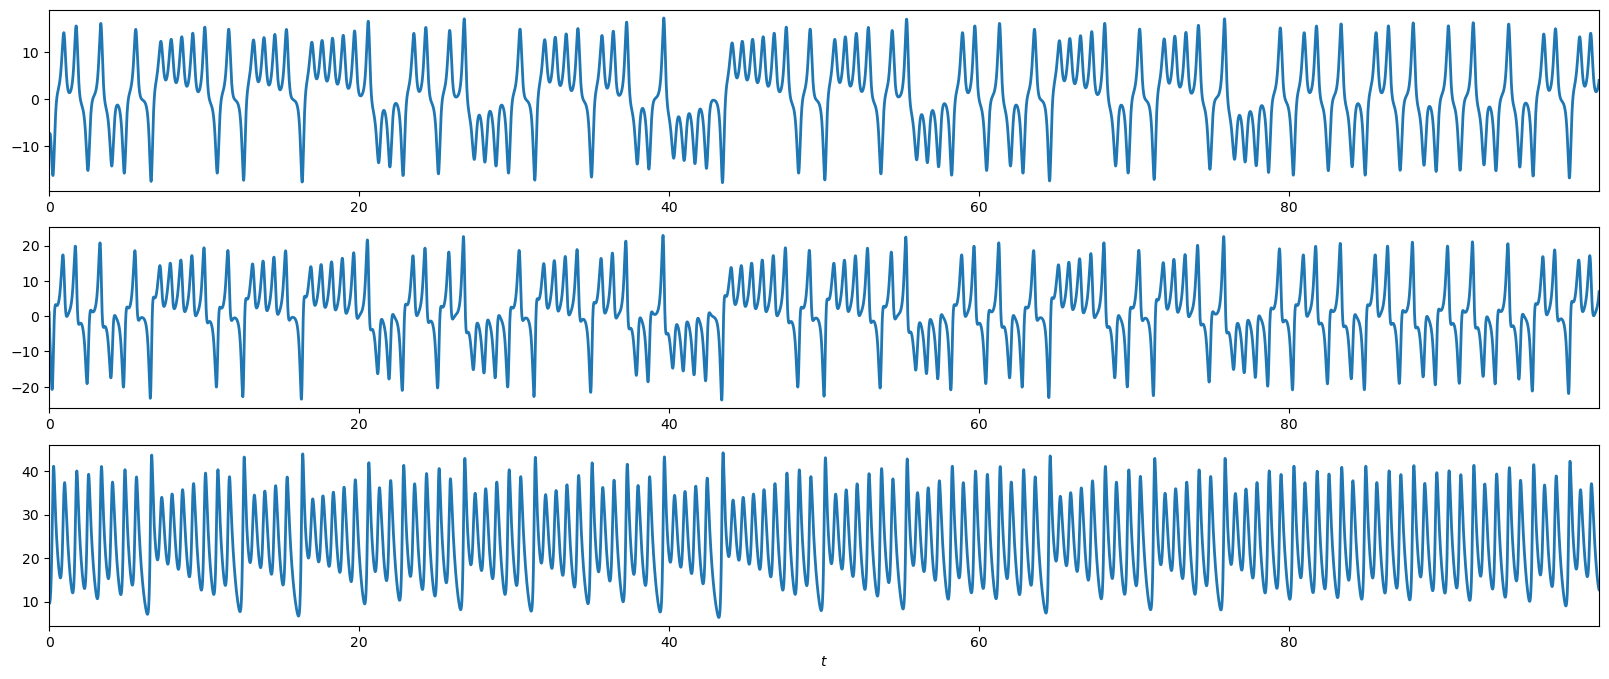

Train shape: (8000, 3), Test shape: (2000, 3)


In [15]:
tN = 100.0
dt = 0.01
test_perc = 0.2
U,t = orc.data.lorenz63(tN=tN, dt=dt)
vis.plot_time_series(U,t)

# train test split 
split_idx = int((1 - test_perc) * U.shape[0])
U_train = U[:split_idx]
U_test = U[split_idx:]
t_train = t[:split_idx]
t_test = jnp.arange(U_test.shape[0]) * dt

print(f"Train shape: {U_train.shape}, Test shape: {U_test.shape}")

## Train it (Continuous)

In [16]:
def train_CESN_forecaster(model, train_seq, train_ts):
    beta = 1e-8

    r0 = jnp.zeros(
            (
                model.embedding.chunks,
                model.res_dim,
            ),
            dtype=model.dtype,
        )
    


    R = model.force(train_seq, r0, train_ts)

    # R_og = R 
    U = train_seq

    R = R[:, 0, :].T
    U = U.T

    A = (R@R.T + beta * jnp.eye(model.res_dim, dtype = jnp.float64))
    B = R @ U.T 

    X = jax.scipy.linalg.solve(A,B, assume_a="sym").T


    def where(m):
        return m.readout.wout

    model = eqx.tree_at(where, model, jnp.expand_dims(X, 0))

    R = jnp.expand_dims(R.T, 1)
    return model, R

In [17]:
esn = orc.models.CESNForecaster(data_dim=U_train.shape[1], res_dim=200, gamma = 50.0)
esn, R = train_CESN_forecaster(model=esn,train_seq=U_train, train_ts = t_train)

In [18]:
print(jnp.linalg.norm(esn.readout.wout))

266.5867630149285


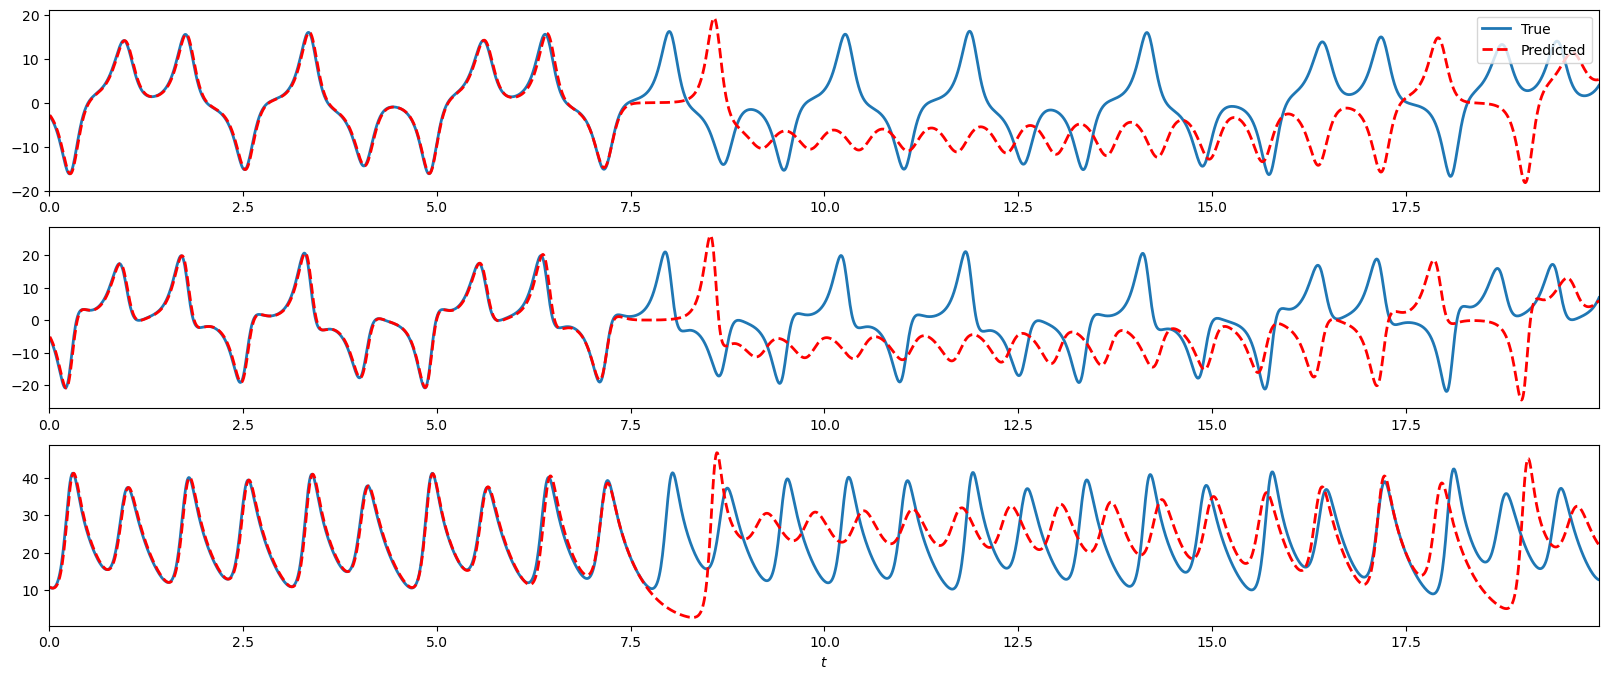

In [19]:
U_pred = esn.forecast(ts = t_test, res_state=R[-1])

vis.plot_time_series(
    [U_test[1:],U_pred],
    t_test[1:],
    line_formats=["-", "r--"],
    time_series_labels=["True", "Predicted"]
)

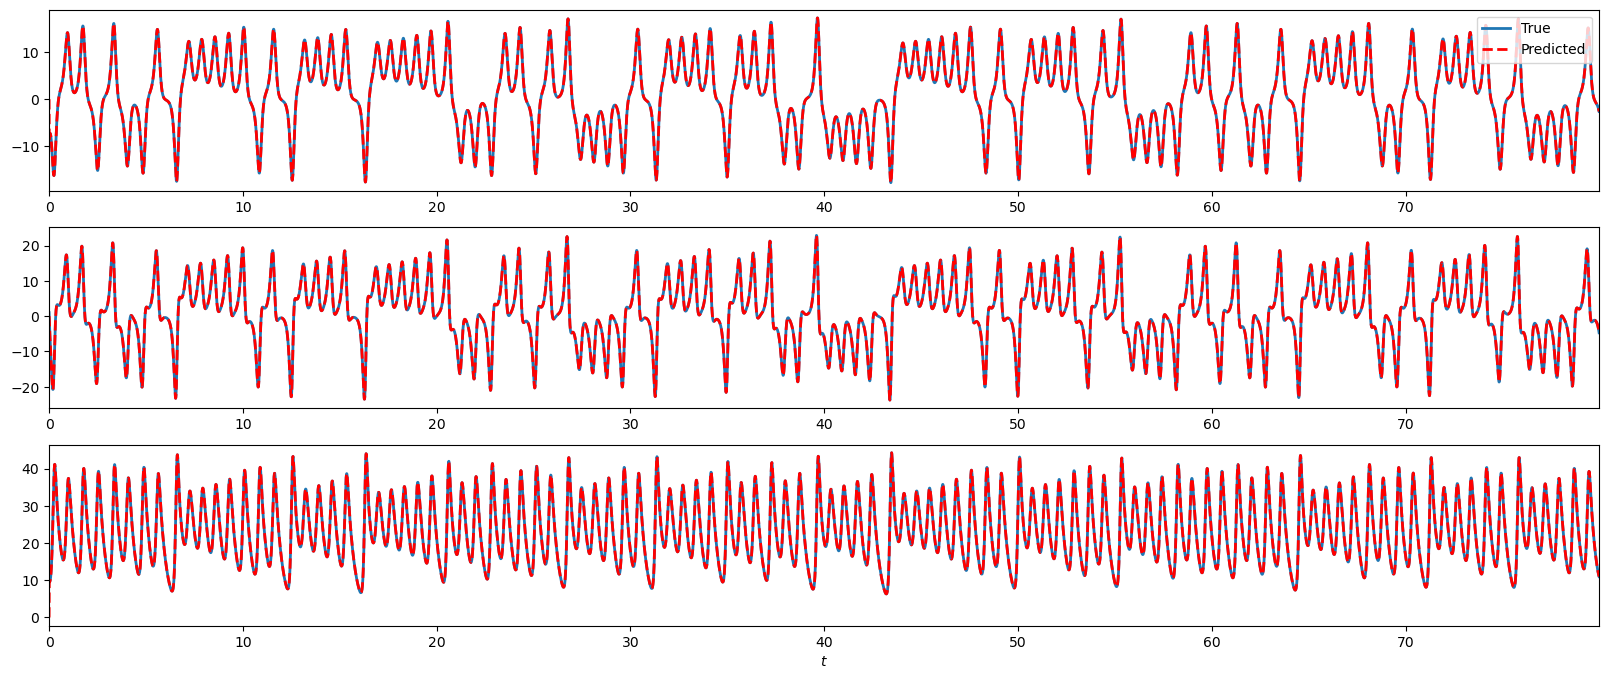

(8000, 3)

In [20]:
U_pred_train = esn.readout(R)
vis.plot_time_series(
    [U_train,U_pred_train],
    t_train,
    line_formats=["-", "r--"],
    time_series_labels=["True", "Predicted"]
)
U_pred_train.shape